<a href="https://colab.research.google.com/github/Poorya0071/NLP_TensorFlow/blob/main/BBC_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BBC Text news classification based on 5 categories

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [4]:
import zipfile

zip_ref = zipfile.ZipFile("bbc-text.csv.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [7]:

data = pd.read_csv('/content/bbc-text.csv')

In [8]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


# Check the Data imbalance 

In [10]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

# Split Dataset 

In [17]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(data["text"].to_numpy(),
                                                                            data['category'].to_numpy(),
                                                                            test_size=0.15, # dedicate 10% of samples to validation set
                                                                            random_state=42)

#Use OneHotEncoder to convert string labels to numbers

In [19]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Check what training labels look like
train_labels_encoded

array([0, 0, 3, ..., 4, 3, 4])

# SKlearn Baseline mode

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 94.91%


In [24]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

387

# TextVector and Embedding

In [26]:
max_vocab_length = 60000 # max number of words to have in our vocabulary
max_length = 387 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [27]:
text_vectorizer.adapt(train_sentences)

In [28]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

# LSTM model

In [32]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_2_history = model_2.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels_one_hot,
                              steps_per_epoch=len(train_sentences)//16,
                              epochs=15,
                              validation_data=(val_sentences, val_labels_one_hot),
                              validation_steps=len(val_sentences)
                              )

(None, 387, 128)
(None, 64)
Epoch 1/15
118/118 [==============================] - 26s 212ms/step - loss: 1.5326 - accuracy: 0.3026 - val_loss: 1.4513 - val_accuracy: 0.3353
Epoch 2/15
118/118 [==============================] - 25s 216ms/step - loss: 1.4744 - accuracy: 0.4114 - val_loss: 1.4643 - val_accuracy: 0.3952
Epoch 3/15
118/118 [==============================] - 25s 209ms/step - loss: 1.3254 - accuracy: 0.4134 - val_loss: 1.2096 - val_accuracy: 0.4042
Epoch 4/15
118/118 [==============================] - 24s 208ms/step - loss: 1.1611 - accuracy: 0.5118 - val_loss: 1.3998 - val_accuracy: 0.3922
Epoch 5/15
118/118 [==============================] - 28s 241ms/step - loss: 1.1593 - accuracy: 0.5314 - val_loss: 1.3181 - val_accuracy: 0.4102
Epoch 6/15
118/118 [==============================] - 27s 225ms/step - loss: 0.9828 - accuracy: 0.5710 - val_loss: 1.2061 - val_accuracy: 0.5419
Epoch 7/15
118/118 [==============================] - 29s 246ms/step - loss: 0.9924 - accuracy: 0.5534

118/118 [==============================] - 9s 73ms/step - loss: 0.5991 - accuracy: 0.7063 - val_loss: 0.9904 - val_accuracy: 0.5958


# Transfer Learning

In [33]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [40]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_2_history = model_2.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels_one_hot,
                              steps_per_epoch=len(train_sentences),
                              epochs=5,
                              validation_data=(val_sentences, val_labels_one_hot),
                              validation_steps=len(val_sentences)
                              )

Epoch 1/5
1891/1891 [==============================] - 13s 6ms/step - loss: 0.2330 - accuracy: 0.9434 - val_loss: 0.0761 - val_accuracy: 0.9731
Epoch 2/5
1891/1891 [==============================] - 13s 7ms/step - loss: 0.0420 - accuracy: 0.9857 - val_loss: 0.0605 - val_accuracy: 0.9820
Epoch 3/5
1891/1891 [==============================] - 12s 6ms/step - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.0775 - val_accuracy: 0.9760
Epoch 4/5
1891/1891 [==============================] - 14s 7ms/step - loss: 0.0172 - accuracy: 0.9931 - val_loss: 0.0659 - val_accuracy: 0.9701
Epoch 5/5
1891/1891 [==============================] - 12s 6ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0633 - val_accuracy: 0.9790


In [43]:
model_2.evaluate(val_sentences, val_labels_one_hot)

11/11 [==============================] - 1s 59ms/step - loss: 0.0633 - accuracy: 0.9790


[0.06329511851072311, 0.9790419340133667]

# Prediction on a text from the Internet

In [45]:
sample_data = "Today we present 20 players whose names you'll hear about in trade rumours over the next seven weeks. We'll update this list as we go and situations change, to reflect injuries, news and other developments that may change the landscape."
model_2.predict([sample_data])

1/1 [==============================] - 0s 462ms/step


array([[0.04932658, 0.00219719, 0.00186718, 0.8588744 , 0.08773471]],
      dtype=float32)

In [49]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['business', 'entertainment', 'politics', 'sport', 'tech'],
       dtype=object))

### The prediction tells us the sample sentence belongs to Sport category with 86%

# Dense Model

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [53]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
print(x.shape)

x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels_one_hot,
                              steps_per_epoch=len(train_sentences),
                              epochs=5,
                              validation_data=(val_sentences, val_labels_one_hot),
                              validation_steps=len(val_sentences)
                              )

(None, 387, 128)
(None, 64)
Epoch 1/5
1891/1891 [==============================] - 91s 48ms/step - loss: 0.5906 - accuracy: 0.7842 - val_loss: 0.1434 - val_accuracy: 0.9521
Epoch 2/5
1891/1891 [==============================] - 91s 48ms/step - loss: 0.0340 - accuracy: 0.9910 - val_loss: 0.1018 - val_accuracy: 0.9701
Epoch 3/5
1891/1891 [==============================] - 88s 47ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0785 - val_accuracy: 0.9671
Epoch 4/5
1891/1891 [==============================] - 88s 47ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0681 - val_accuracy: 0.9731
Epoch 5/5
1891/1891 [==============================] - 87s 46ms/step - loss: 1.7886e-04 - accuracy: 1.0000 - val_loss: 0.0711 - val_accuracy: 0.9731


In [54]:
model_3.predict([sample_data])

1/1 [==============================] - 0s 136ms/step


array([[0.0757347 , 0.13835402, 0.01345917, 0.77161586, 0.00083634]],
      dtype=float32)

In [71]:
y_pred_3 = model_3.predict(val_sentences)

11/11 [==============================] - 0s 9ms/step


In [73]:
y_pred_2 = model_2.predict(val_sentences)

11/11 [==============================] - 1s 54ms/step


# Model Evaluation with confusion matrix

In [81]:
y_pred_model_o = model_0.predict(val_sentences)

In [74]:
pred_ls_model_3 = []
for i in range(len(val_sentences)):
  pred = y_pred_3[i].argmax()
  pred_ls_model_3.append(pred)

In [75]:
pred_ls_model_2 = []
for i in range(len(val_sentences)):
  pred = y_pred_2[i].argmax()
  pred_ls_model_2.append(pred)

In [76]:
from sklearn.metrics import confusion_matrix


In [82]:
# for baseline
confusion_matrix(val_labels_encoded, y_pred_model_o)

array([[63,  0,  4,  0,  0],
       [ 2, 53,  4,  2,  2],
       [ 1,  0, 66,  0,  0],
       [ 0,  0,  0, 81,  0],
       [ 1,  0,  0,  1, 54]])

In [77]:
# for model_2 Transfer Learning
confusion_matrix(val_labels_encoded, pred_ls_model_2)

array([[62,  0,  3,  0,  2],
       [ 0, 61,  1,  0,  1],
       [ 0,  0, 67,  0,  0],
       [ 0,  0,  0, 81,  0],
       [ 0,  0,  0,  0, 56]])

In [78]:
# for model_3 Dense Model
confusion_matrix(val_labels_encoded, pred_ls_model_3)

array([[61,  0,  3,  1,  2],
       [ 1, 62,  0,  0,  0],
       [ 1,  0, 66,  0,  0],
       [ 0,  0,  1, 80,  0],
       [ 0,  0,  0,  0, 56]])

# Conclusion

The transfer learning embedding layer and Dense model work very well and beats the basemodel.

In [69]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] 

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

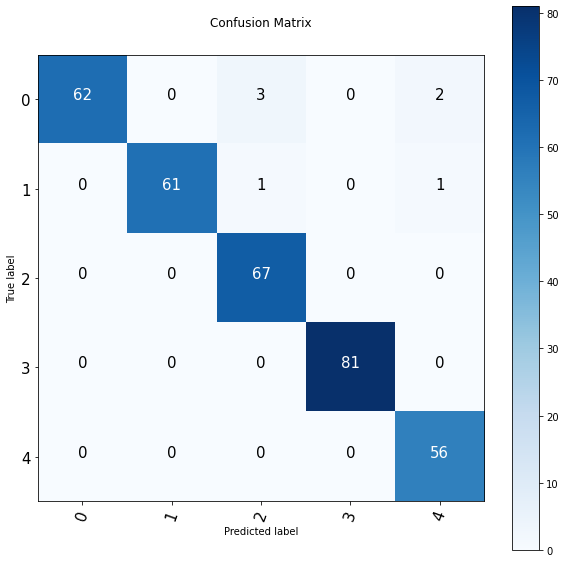

In [79]:
make_confusion_matrix(val_labels_encoded, pred_ls_model_2, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False)

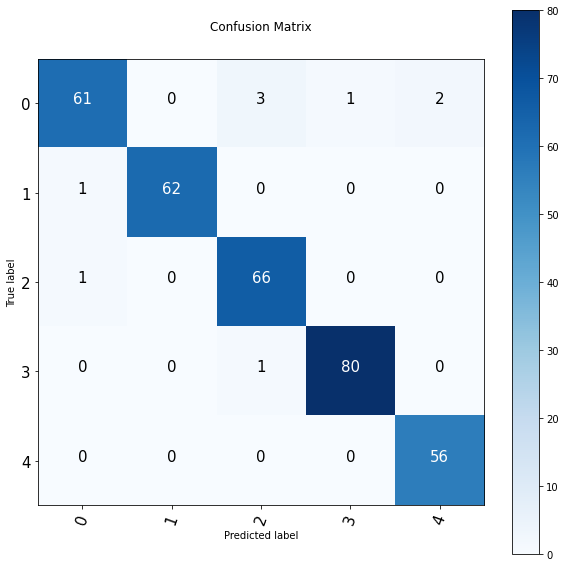

In [70]:
make_confusion_matrix(val_labels_encoded, pred_ls_model_3, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False)

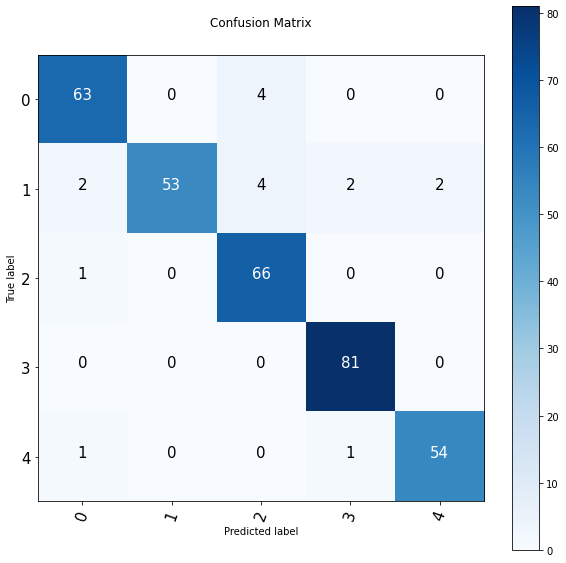

In [83]:
make_confusion_matrix(val_labels_encoded, y_pred_model_o, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False)
